## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist

## Loading and merging data

In [55]:
FPS_1 = 60
FPS_2 = 30

start_time = pd.Timestamp('2025-10-06 18:00:00')
df1 = pd.read_csv('../outputs/pipeline_run/tracks_video_1_60fps.csv')
df2 = pd.read_csv('../outputs/pipeline_run/tracks_video_2_30fps.csv')
df2['frame'] = df1['frame'].max() + 2 + df2['frame']
df2['tracker_id'] = df2['tracker_id'] + df1['tracker_id'].max()
df1['time_s'] = df1['frame'] / FPS_1
df2['time_s'] = df2['frame'] / FPS_2
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined['timestamp'] = start_time + pd.to_timedelta(df_combined['time_s'], unit='s')
df_track = df_combined.drop(
    columns=['x_min', 'x_max', 'y_min', 'y_max', 'class_id', 'confidence', 'class_name', 'frame', 'time_s'])
df_track


,tracker_id,lv95_E,lv95_N,timestamp
0,1,2680854.2,1248089.4,2025-10-06 18:00:00
1,2,2680871.8,1248076.8,2025-10-06 18:00:00
2,3,2680877.2,1248072.2,2025-10-06 18:00:00
3,4,2680881.8,1248067.9,2025-10-06 18:00:00
4,5,2680846.8,1248093.6,2025-10-06 18:00:00
...,...,...,...,...
362690,10553,2680876.2,1248075.4,2025-10-06 19:06:42
362691,10650,2680864.8,1248084.1,2025-10-06 19:06:42
362692,10694,2680849.2,1248095.1,2025-10-06 19:06:42
362693,10697,2680838.5,1248102.9,2025-10-06 19:06:42


## Computing speed for each unique tracker

In [56]:
# sorting the dataset so each vehicle's positions are ordered in time
df_track = df_track.sort_values(['timestamp', 'tracker_id'])
# for each vehicle, shift the coordinates by one time step forward
# this creates a new column where each row holds the previous position of the vehicle
df_track['lv95_E_shift'] = df_track.groupby('tracker_id')['lv95_E'].shift()
df_track['lv95_N_shift'] = df_track.groupby('tracker_id')['lv95_N'].shift()
# computing the time difference between the consecutive positions for each vehicle (in seconds)
df_track['time_diff'] = (df_track['timestamp'] - df_track.groupby('tracker_id')['timestamp'].shift()).dt.total_seconds()
# computing the euclidean distance between the consecutive positions (in meters)
df_track['distance'] = np.sqrt(
    (df_track['lv95_E'] - df_track['lv95_E_shift']) ** 2 +
    (df_track['lv95_N'] - df_track['lv95_N_shift']) ** 2
)
# calculating instantaneous speed (in meters per second)
df_track['speed_mps'] = df_track['distance'] / df_track['time_diff']
# dropping first NaN rows (which have no previous point)
df_track = df_track.dropna()
# clipping unrealistic speeds (to remove tracking noise/outliers)
# between about 0 and 43 km/h
df_track['speed_mps'] = df_track['speed_mps'].clip(lower=0, upper=12)
df_track['speed_kmh'] = df_track['speed_mps'] * 3.6
df_track


,tracker_id,lv95_E,lv95_N,timestamp,lv95_E_shift,lv95_N_shift,time_diff,distance,speed_mps,speed_kmh
13,1,2680854.2,1248089.4,2025-10-06 18:00:00.066666667,2680854.2,1248089.4,0.066667,0.000000,0.000000,0.000000
14,2,2680871.8,1248076.8,2025-10-06 18:00:00.066666667,2680871.8,1248076.8,0.066667,0.000000,0.000000,0.000000
15,3,2680877.2,1248072.2,2025-10-06 18:00:00.066666667,2680877.2,1248072.2,0.066667,0.000000,0.000000,0.000000
16,4,2680881.8,1248067.9,2025-10-06 18:00:00.066666667,2680881.8,1248067.9,0.066667,0.000000,0.000000,0.000000
17,5,2680846.8,1248093.6,2025-10-06 18:00:00.066666667,2680846.8,1248093.6,0.066667,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
362690,10553,2680876.2,1248075.4,2025-10-06 19:06:42.000000000,2680876.2,1248075.5,0.066667,0.100000,1.500000,5.400000
362691,10650,2680864.8,1248084.1,2025-10-06 19:06:42.000000000,2680864.8,1248084.2,0.066667,0.100000,1.500000,5.400000
362692,10694,2680849.2,1248095.1,2025-10-06 19:06:42.000000000,2680849.0,1248095.2,0.066667,0.223607,3.354102,12.074767
362693,10697,2680838.5,1248102.9,2025-10-06 19:06:42.000000000,2680838.2,1248102.9,0.066667,0.300000,4.500000,16.200000


In [57]:
avg_speed = df_track['speed_kmh'].mean()
print(f"Average speed: {avg_speed:.2f} km/h")
std_speed = df_track['speed_kmh'].std()
print(f"Speed standard deviation: {std_speed:.2f} km/h")

Average speed: 3.70 km/h
Speed standard deviation: 6.11 km/h


## Identifying and cluster stationary vehicles by time

In [58]:
# filtering vehicles that are moving slower than 0.5 m/s (1.8 km/h)
stationary = df_track[df_track['speed_mps'] < 0.5].copy()
# rounding down timestamps to the nearest minute --> all stationary detections between 18:00:00–18:00:59 are grouped together
stationary['minute'] = stationary['timestamp'].dt.floor('1min')
# this function takes all stationary points within the same minute and finds which ones are close enough in space to form a queue (cluster)
def cluster_by_time(group):
    coords = group[['lv95_E', 'lv95_N']].to_numpy()
    # eps=5 is the maximum distance (in meters) between two vehicles
    # min_samples=2 means that at least two vehicles are needed to form a queue
    clustering = DBSCAN(eps=5, min_samples=2).fit(coords)
    group['queue_id'] = clustering.labels_
    return group

stationary = stationary.groupby('minute', group_keys=False).apply(cluster_by_time)

/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_83702/44138145.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stationary = stationary.groupby('minute', group_keys=False).apply(cluster_by_time)


## Calculating queue sizes and maximum queue length

In [59]:
# approximating the queue length (distance between the first and last vehicle in the queue)
def queue_length_m(group):
    coords = group[['lv95_E', 'lv95_N']].to_numpy()
    if len(coords) < 2:
        return 0
    return pdist(coords).max() # max pairwise distance in meters

# grouping by time and queue
queue_lengths = (
    stationary[stationary['queue_id'] >= 0]
    .groupby(['minute', 'queue_id'])
    .apply(queue_length_m)
    .reset_index(name='queue_length_m')
)

# computing the maximum and average queue length
max_queue_length_m = queue_lengths['queue_length_m'].max()
avg_queue_length_m = queue_lengths['queue_length_m'].mean()
std_queue_length_m = queue_lengths['queue_length_m'].std()

print(f"Maximum queue length: {max_queue_length_m:.2f} m")
print(f"Average queue length: {avg_queue_length_m:.2f} m")
print(f"Queue length standard deviation: {std_queue_length_m:.2f} m")

Maximum queue length: 86.75 m
Average queue length: 50.46 m
Queue length standard deviation: 38.75 m


/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_83702/1536409833.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(queue_length_m)


## Calculating average time spent in the queue

In [60]:
in_queue = stationary[stationary['queue_id'] >= 0]
time_in_queue = (
    in_queue.groupby('tracker_id')['minute']
    .agg(['min', 'max'])
    .assign(duration=lambda x: (x['max'] - x['min']).dt.total_seconds())
)
avg_time_in_queue = time_in_queue['duration'].mean()
std_time_in_queue = time_in_queue['duration'].std()
print(f"Average time in queue: {avg_time_in_queue:.2f} minutes")
print(f"Time in queue standard deviation: {std_time_in_queue:.2f} minutes")

Average time in queue: 3.50 minutes
Time in queue standard deviation: 17.13 minutes


## Visualizing queue length over time and displaying average queue duration

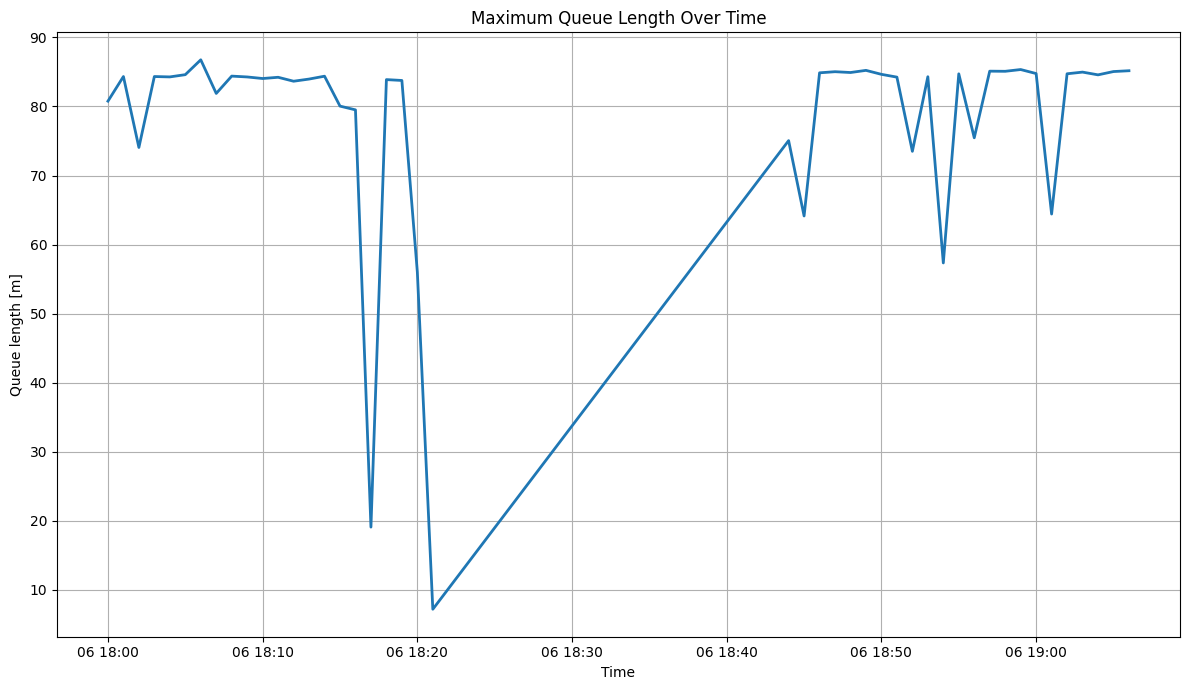

In [61]:
ts_max = (queue_lengths
          .groupby('minute', as_index=False)['queue_length_m']
          .max())

plt.figure(figsize=(12, 7))
plt.plot(ts_max['minute'], ts_max['queue_length_m'], linewidth=2)
plt.title('Maximum Queue Length Over Time')
plt.xlabel('Time')
plt.ylabel('Queue length [m]')
plt.grid()
plt.tight_layout()
plt.show()